## Clustering method

This tutorial gives a bit more detail about clustering methods and how to implement your own.


In [1]:
# Prerequisites
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams["figure.dpi"] = 300
plt.rcParams["figure.figsize"] = (12, 5)

# Include this once we have a published release to fetch test data
# from toad.utils import download_test_data
# download_test_data()

In [2]:
from toad import TOAD
from toad.shifts import ASDETECT

td = TOAD("test_data/garbe_2020_antarctica.nc", time_dim="GMST")
td.data = td.data.coarsen(x=3, y=3, GMST=3, boundary="trim").reduce(np.mean)

In [3]:
# shifts have been precomputed
td.compute_shifts("thk", method=ASDETECT(), overwrite=True)

INFO: Applying detector ASDETECT to thk


The `td.compute_clusters` function accepts clustering methods from the `sklearn.cluster` module.


In [4]:
from sklearn.cluster import DBSCAN, HDBSCAN

# HDBSCAN
td.compute_clusters(
    "thk",
    method=HDBSCAN(
        min_cluster_size=25,
        min_samples=5,  # optional, defaults to min_cluster_size
        cluster_selection_epsilon=0.1,  # optional, defauls to 0
        metric="euclidean",  # optional, defaults to 'euclidean'
    ),
    shift_threshold=0.8,
)

# DBSCAN
td.compute_clusters(
    "thk",
    method=DBSCAN(
        eps=0.1,
        min_samples=5,
        metric="euclidean",  # optional, defaults to 'euclidean'
    ),
    shift_threshold=0.8,
)

INFO: Applying clusterer HDBSCAN to thk_dts
INFO: Detected 25 clusters
INFO: Variable thk_dts_cluster already exists. Using thk_dts_cluster_1 instead.
INFO: Applying clusterer DBSCAN to thk_dts
INFO: Detected 48 clusters



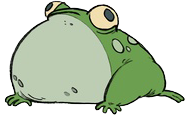

In [5]:
td

## Defining your own clustering method

You can also define your own clustering method by extending the `sklearn.base.ClusterMixin` and `sklearn.base.BaseEstimator` classes:


In [6]:
from sklearn.base import ClusterMixin, BaseEstimator


# Your custom clustering class must inherit from ClusterMixin and BaseEstimator
class MyClusterer(ClusterMixin, BaseEstimator):
    # Pass params to your method here
    def __init__(self, my_param):
        self.my_param = my_param

    # required method to perform clustering
    def fit_predict(self, coords: np.ndarray, weights=None, **kwargs):
        cluster_labels_array = ...  # your clustering algorithm here
        return cluster_labels_array


# Then apply it with TOAD
# td.compute_clusters('thk',
#     method=MyClusterer(
#         my_param=(1, 2.0, 2.0), # time, x, y thresholds
#     ),
#     shift_threshold=0.8,
#     overwrite=True,
# )

Real example of a custom clustering method:


In [7]:
from sklearn.base import BaseEstimator, ClusterMixin


class ExampleClusterer(ClusterMixin, BaseEstimator):
    # required method
    def __init__(self, my_param=(0.5, 1.0, 1.0)):
        self.my_param = my_param

    # required method
    def fit_predict(self, coords: np.ndarray, weights=None, **kwargs):
        # Perform extremely crude clustering
        clusters = []
        cluster_labels_array = []
        for point in coords:
            for i, centroid in enumerate(clusters):
                if all(abs(point - centroid) <= self.my_param):
                    break
            else:
                clusters.append(point)
                i = len(clusters) - 1
            cluster_labels_array.append(i)

        return cluster_labels_array


td.compute_clusters(
    "thk",
    method=ExampleClusterer(
        my_param=(0.5, 2.0, 2.0),  # time, x, y thresholds
    ),
    shift_threshold=0.9,
    # overwrite=True,
)

INFO: Variable thk_dts_cluster already exists. Using thk_dts_cluster_2 instead.
INFO: Applying clusterer ExampleClusterer to thk_dts
INFO: Detected 20 clusters



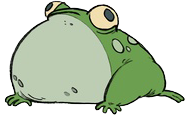

In [8]:
td

We can inspect all method params in the attributes

In [9]:
# get attributes of last cluster variable
td.get_clusters(td.cluster_vars[-1]).attrs

{'cluster_ids': array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20]),
 'shift_threshold': 0.9,
 'shift_sign': 'absolute',
 'scaler': 'StandardScaler',
 'time_scale_factor': 1,
 'n_data_points': 11445,
 'method_name': 'ExampleClusterer',
 'toad_version': '0.3',
 'base_variable': 'thk',
 'shifts_variable': 'thk_dts',
 'variable_type': 'cluster',
 'method_my_param': '(0.5, 2.0, 2.0)'}

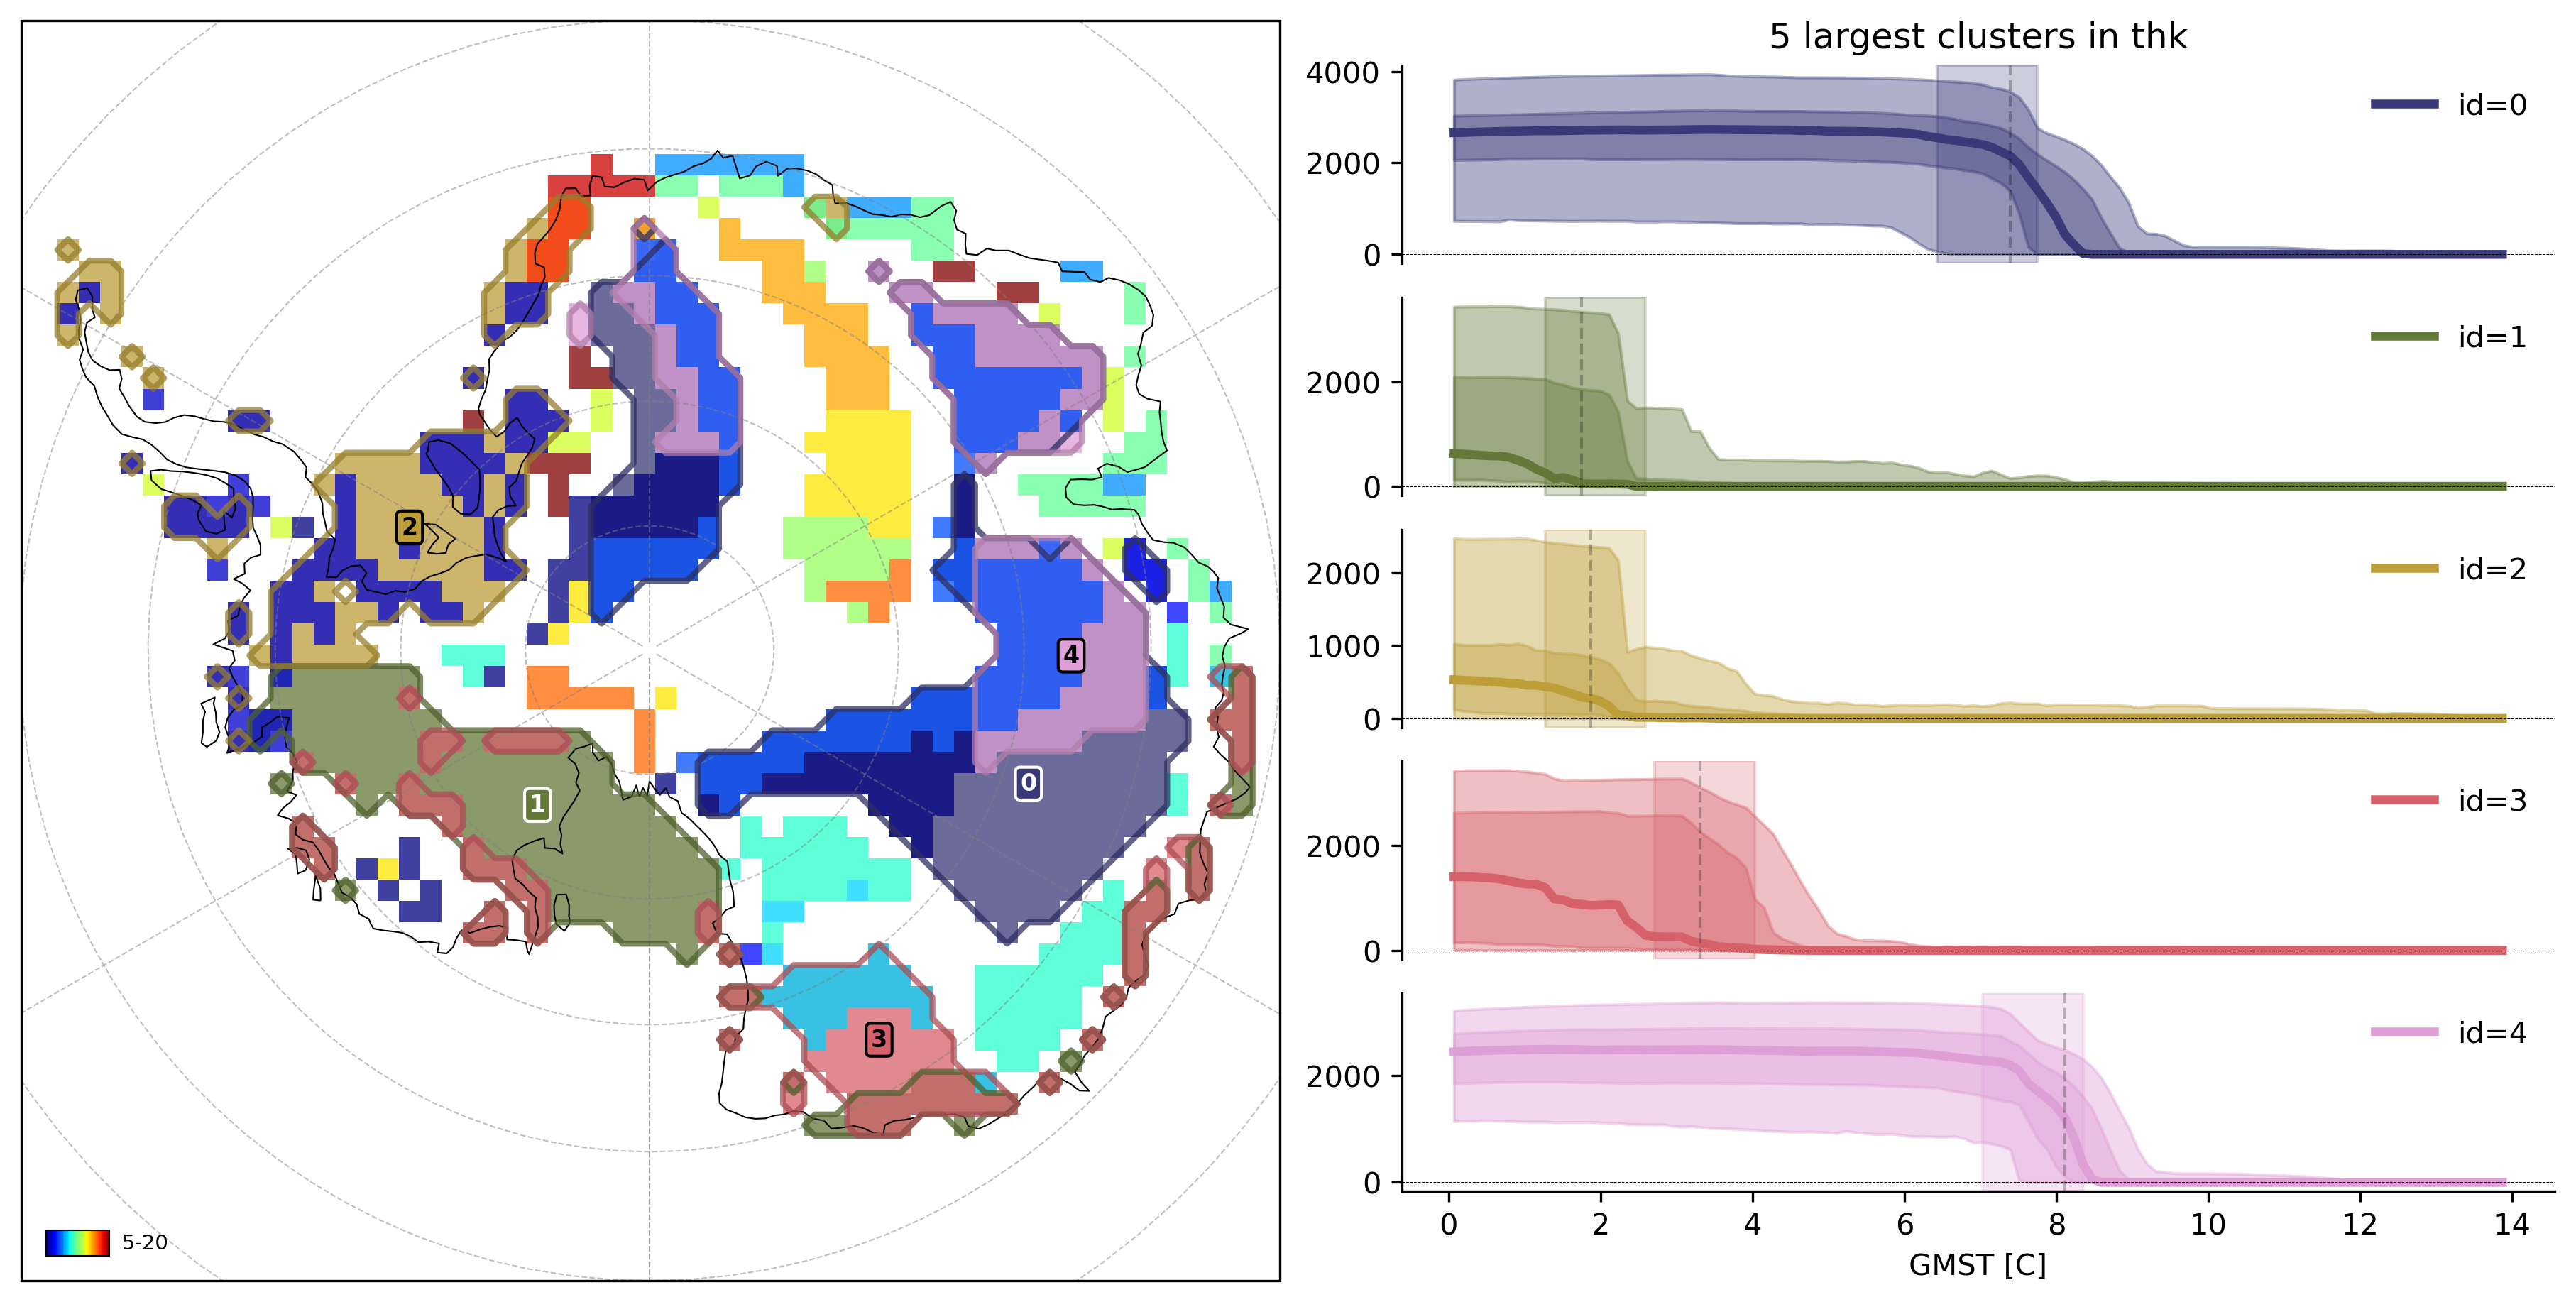

In [10]:
td.plotter().cluster_overview("thk_dts_cluster_2", projection="south_pole");